# Лабораторная работа №3

## Предобработка данных и логистическая регрессия

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [56]:
import numpy as np

import pandas as pd
from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt

import imblearn

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso

from sklearn.metrics import roc_auc_score

## Подготовка данных

#### Чтение датасета из файла 

In [3]:
data = pd.read_csv("data/grants.csv")

data.head()

,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,1,21A,50A,A,230202.0,50.0,230203.0,30.0,230204.0,20.0,...,3098.0,31.0,Yes,>=0 to 5,2.0,0.0,0.0,4.0,2.0,0.0
1,1,4D,10A,D,320801.0,100.0,0.0,0.0,0.0,0.0,...,2553.0,25.0,Yes,>=0 to 5,3.0,1.0,0.0,2.0,0.0,0.0
2,0,NaN,NaN,NaN,320602.0,50.0,321004.0,30.0,321015.0,20.0,...,2813.0,25.0,NaN,Less than 0,1.0,5.0,0.0,7.0,2.0,0.0
3,0,51C,20C,A,291503.0,60.0,321402.0,40.0,0.0,0.0,...,2553.0,25.0,NaN,more than 15,2.0,1.0,5.0,6.0,9.0,1.0
4,0,24D,30B,NaN,380107.0,100.0,0.0,0.0,0.0,0.0,...,2923.0,25.0,NaN,Less than 0,0.0,2.0,0.0,0.0,0.0,0.0


In [4]:
data.shape

(6000, 39)

In [5]:
data.dropna().shape

(213, 39)

Очевидно, что имея такую количественную разницу между "сырыми" и "чистыми" данными, необходимо придумать способ перенести NaN-признаки в зону доступных для обучения.  

#### Разбиение датасета на матрицу "объект-признак" и прогнозируемый параметр

In [6]:
X = data.drop(["Grant.Status"], axis=1)
y = data["Grant.Status"]

#### Разделение числовых и категориальных признаков 

In [7]:
numeric_columns = [
    "RFCD.Percentage.1",
    "RFCD.Percentage.2",
    "RFCD.Percentage.3",
    "RFCD.Percentage.4",
    "RFCD.Percentage.5",
    "SEO.Percentage.1",
    "SEO.Percentage.2",
    "SEO.Percentage.3",
    "SEO.Percentage.4",
    "SEO.Percentage.5",
    "Year.of.Birth.1",
    "Number.of.Successful.Grant.1",
    "Number.of.Unsuccessful.Grant.1"
]

categorical_columns = list(set(X.columns.values.tolist()) - set(numeric_columns))

## Задание 0. Обработка пропущенных значений

In [8]:
X_real_zeros = X[numeric_columns].fillna(0)

In [9]:
X_real_means = X[numeric_columns].fillna(X[numeric_columns].mean())

In [10]:
X_cat = X[categorical_columns].fillna("NA").astype(str)

#### Кодирование категориальных признаков

In [11]:
encoder = DictVectorizer(sparse=False)

In [12]:
X_cat_oh = encoder.fit_transform(X_cat.T.to_dict().values())

## Создание обучающей выборки

#### Разбиение на обучающую и тестовую выборки

In [13]:
X_train_real_zeros, X_test_real_zeros = train_test_split(X_real_zeros, test_size=0.3, random_state=0)

In [14]:
X_train_real_means, X_test_real_means = train_test_split(X_real_means, test_size=0.3, random_state=0)

In [15]:
X_train_cat_oh, X_test_cat_oh = train_test_split(X_cat_oh, test_size=0.3, random_state=0)

In [16]:
y_train, y_test = train_test_split(y, test_size=0.3, random_state=0)

#### Соединение закодированных категориальных данных и заполненных числовых

In [17]:
X_train_real_zeros_cat_oh = np.hstack((X_train_real_zeros, X_train_cat_oh))

In [18]:
X_test_real_zeros_cat_oh = np.hstack((X_test_real_zeros, X_test_cat_oh))

In [19]:
X_train_real_means_cat_oh = np.hstack((X_train_real_means, X_train_cat_oh))

In [20]:
X_test_real_means_cat_oh = np.hstack((X_test_real_means, X_test_cat_oh))

## Обучение путём кросс-валидации

#### Инициализация подбираемых параметров

In [21]:
param_grid = {"C": [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}

#### Инициализация эстиматора

In [22]:
estimator = LogisticRegression(penalty="l2", solver="liblinear")

In [23]:
optimizer = GridSearchCV(estimator, param_grid, cv=3)

#### Функция, определяющая разброс ошибки при отдельном параметре

In [24]:
def plot_scores(optimizer):
    scores = []
    for i in range(len(optimizer.cv_results_["params"])):
        scores.append([
            optimizer.cv_results_["params"][i]["C"], 
            optimizer.cv_results_["mean_test_score"][i],
            optimizer.cv_results_["std_test_score"][i]
        ])

    scores = np.array(scores)
    
    plt.semilogx(scores[:, 0], scores[:,1])
    plt.fill_between(scores[:, 0], scores[:, 1] - scores[:, 2], scores[:, 1] + scores[:, 2], alpha=0.3)
    plt.show()

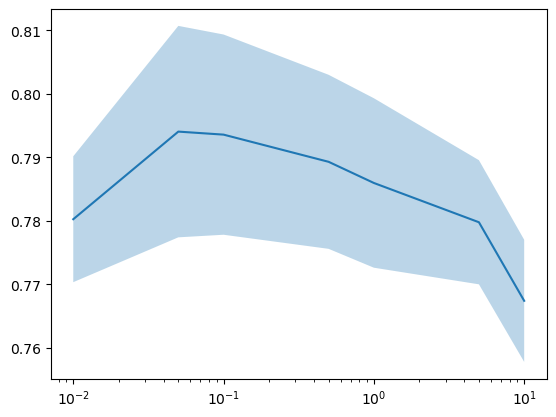

[+] Best C parameter value: {'C': 0.05}
[+] AUC ROC score: 0.8842338869839921


In [25]:
optimizer.fit(X_train_real_zeros_cat_oh, y_train)

plot_scores(optimizer)

print(f"[+] Best C parameter value: {optimizer.best_params_}")
print(f"[+] AUC ROC score: {roc_auc_score(y_test, optimizer.predict_proba(X_test_real_zeros_cat_oh)[:, 1])}")

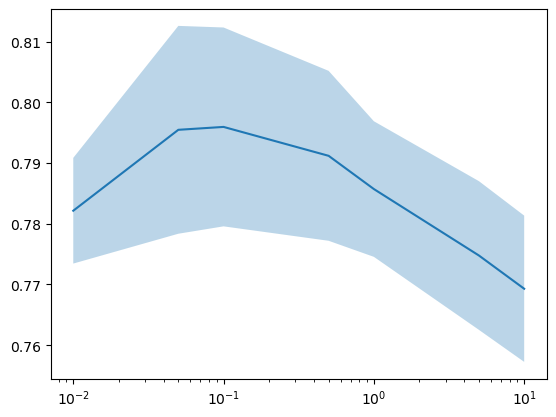

[+] Best C parameter value: {'C': 0.1}
[+] AUC ROC score: 0.8878544974887119


In [26]:
optimizer.fit(X_train_real_means_cat_oh, y_train)

plot_scores(optimizer)

print(f"[+] Best C parameter value: {optimizer.best_params_}")
print(f"[+] AUC ROC score: {roc_auc_score(y_test, optimizer.predict_proba(X_test_real_means_cat_oh)[:, 1])}")

## Масштабирование вещественных признаков

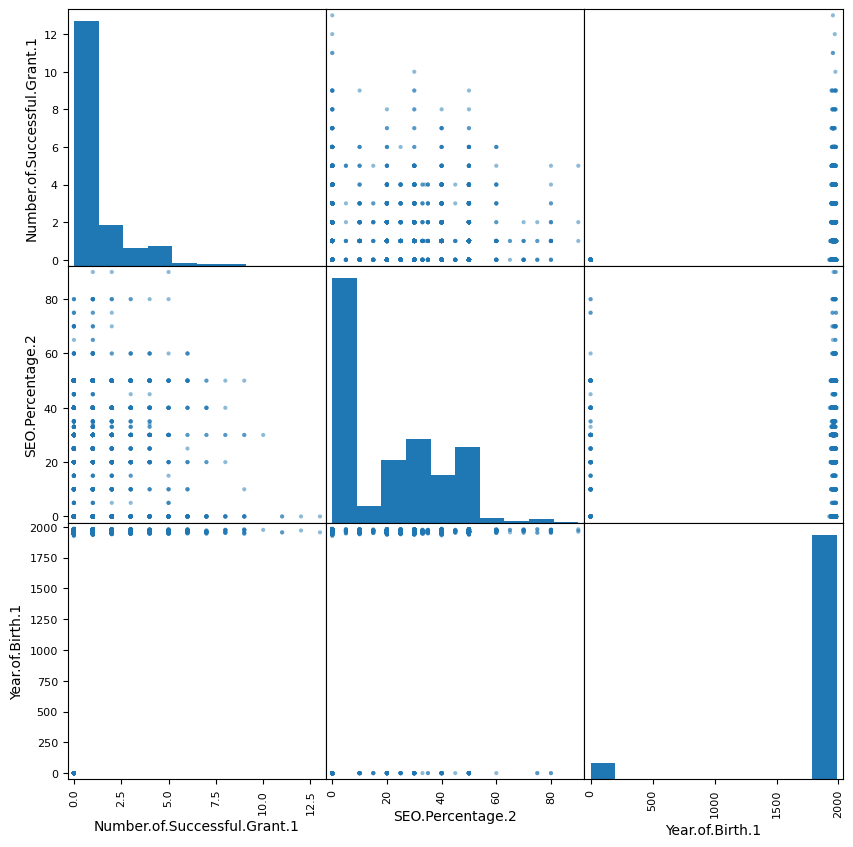

In [27]:
data_numeric = pd.DataFrame(X_train_real_zeros, columns=numeric_columns)

list_cols = [
    "Number.of.Successful.Grant.1",
    "SEO.Percentage.2",
    "Year.of.Birth.1"
]

scatter_matrix(data_numeric[list_cols], alpha=0.5, figsize=(10, 10))

plt.show()

In [28]:
scaler = StandardScaler()

In [29]:
X_train_real_scaled  = scaler.fit_transform(X_train_real_zeros)

In [30]:
X_test_real_scaled = scaler.fit_transform(X_test_real_zeros)

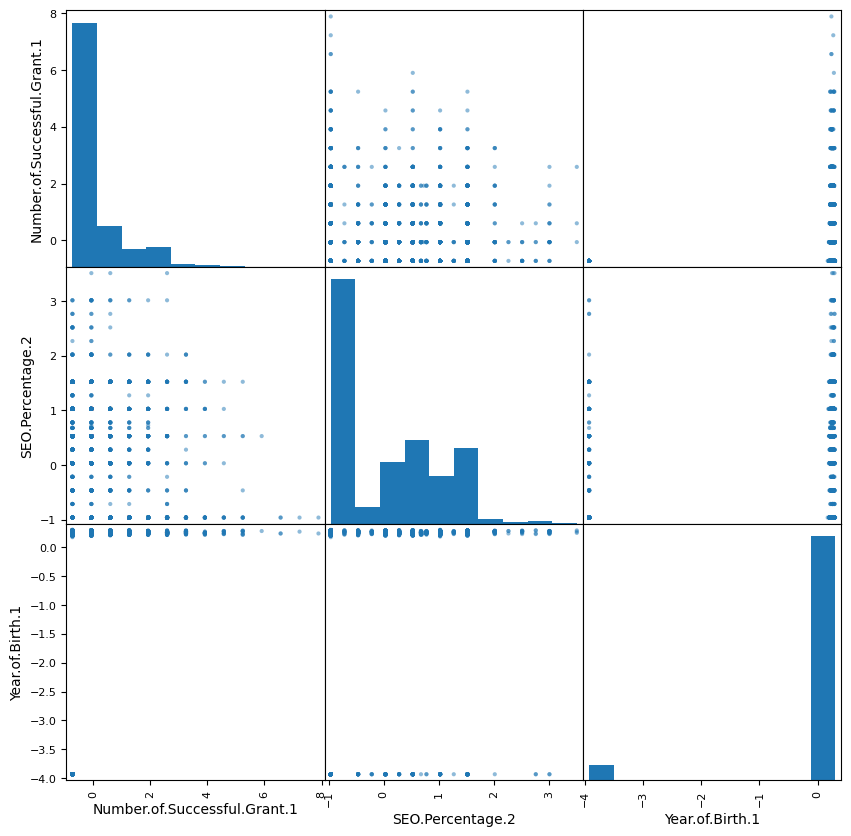

In [31]:
data_numeric_scaled = pd.DataFrame(X_train_real_scaled, columns=numeric_columns)

list_cols = [
    "Number.of.Successful.Grant.1",
    "SEO.Percentage.2",
    "Year.of.Birth.1"
]

scatter_matrix(data_numeric_scaled[list_cols], alpha=0.5, figsize=(10, 10))

plt.show()

## Задание 2. Сравнение качества классификации до и после масштабирования вещественных признаков

In [32]:
X_train_scaled = np.hstack((X_train_real_scaled, X_train_cat_oh))

In [33]:
X_test_scaled = np.hstack((X_test_real_scaled, X_test_cat_oh))

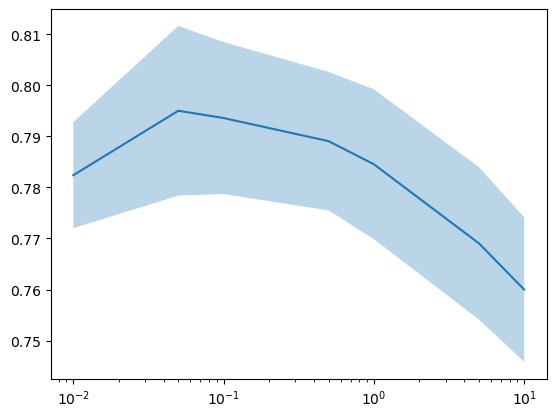

[+] Best C parameter value: {'C': 0.05}
[+] AUC ROC score: 0.8843588636282079


In [34]:
optimizer.fit(X_train_scaled, y_train)

plot_scores(optimizer)

print(f"[+] Best C parameter value: {optimizer.best_params_}")
print(f"[+] AUC ROC score: {roc_auc_score(y_test, optimizer.predict_proba(X_test_scaled)[:, 1])}")

## Задание 3. Балансировка классов

In [35]:
np.sum(y_train == 0), np.sum(y_train == 1)

(2316, 1884)

In [36]:
estimator = LogisticRegression(penalty="l2", solver="liblinear", class_weight="balanced")

In [37]:
optimizer = GridSearchCV(estimator, param_grid, cv=3)

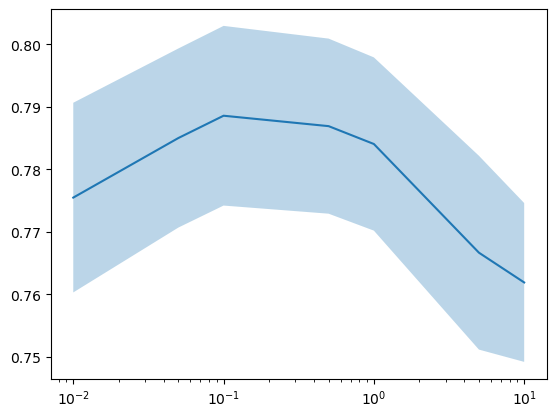

[+] Best C parameter value: {'C': 0.1}
[+] AUC ROC score: 0.8866925859152559


In [38]:
optimizer.fit(X_train_scaled, y_train)

plot_scores(optimizer)

print(f"[+] Best C parameter value: {optimizer.best_params_}")
print(f"[+] AUC ROC score: {roc_auc_score(y_test, optimizer.predict_proba(X_test_scaled)[:, 1])}")

In [39]:
over = imblearn.over_sampling.RandomOverSampler(sampling_strategy=1)

In [40]:
X_smote, y_smote = over.fit_resample(X_train_scaled, y_train)

In [41]:
y_smote.value_counts()

1    2316
0    2316
Name: Grant.Status, dtype: int64

In [42]:
y_test.value_counts()

0    943
1    857
Name: Grant.Status, dtype: int64

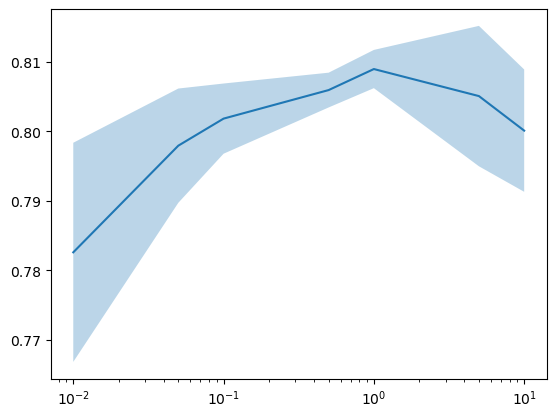

[+] Best C parameter value: {'C': 1}
[+] AUC ROC score: 0.8830695006255019


In [43]:
optimizer.fit(X_smote, y_smote)

plot_scores(optimizer)

print(f"[+] Best C parameter value: {optimizer.best_params_}")
print(f"[+] AUC ROC score: {roc_auc_score(y_test, optimizer.predict_proba(X_test_scaled)[:, 1])}")

## Задание 4. Стратификация выборки

In [45]:
X_train_real_zeros, X_test_real_zeros, y_train, y_test = train_test_split(X_real_zeros, y, stratify=y, random_state=0)

In [46]:
X_train_real_scaled  = scaler.fit_transform(X_train_real_zeros)

In [47]:
X_test_real_scaled = scaler.fit_transform(X_test_real_zeros)

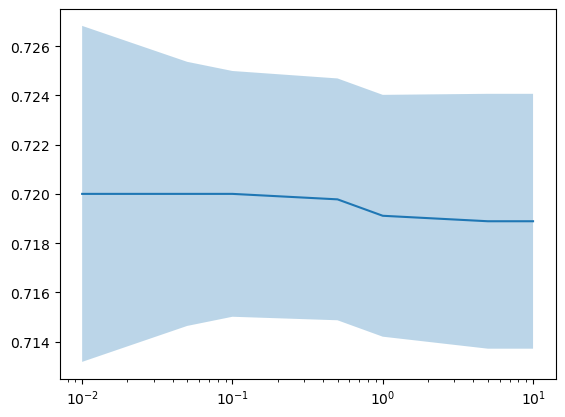

[+] Best C parameter value: {'C': 0.01}
[+] AUC ROC score: 0.7563754422103801


In [48]:
optimizer.fit(X_train_real_scaled, y_train)

plot_scores(optimizer)

print(f"[+] Best C parameter value: {optimizer.best_params_}")
print(f"[+] AUC ROC score: {roc_auc_score(y_test, optimizer.predict_proba(X_test_real_scaled)[:, 1])}")

## Задание 5. Трансформация вещественных признаков

In [50]:
transform = PolynomialFeatures(2)

In [52]:
X_train_poly = transform.fit_transform(X_train_real_scaled)

In [53]:
X_test_poly = transform.fit_transform(X_test_real_scaled)

In [54]:
optimizer = GridSearchCV(LogisticRegression(class_weight="balanced", fit_intercept=False), param_grid, cv=3, n_jobs=-1)

/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimiz

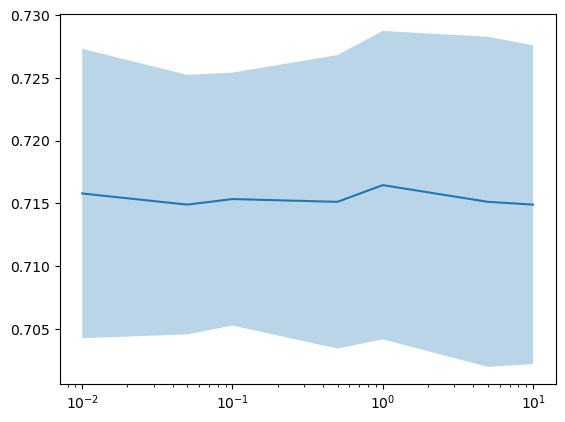

[+] Best C parameter value: {'C': 1}
[+] AUC ROC score: 0.7737109847297479


In [55]:
optimizer.fit(X_train_poly, y_train)

plot_scores(optimizer)

print(f"[+] Best C parameter value: {optimizer.best_params_}")
print(f"[+] AUC ROC score: {roc_auc_score(y_test, optimizer.predict_proba(X_test_poly)[:, 1])}")

## Задание 6. Отбор признаков при помощи регрессии Lasso

In [58]:
lasso = Lasso().fit(X_train_real_zeros, y_train)

In [59]:
print(f"[+] AUC ROC score: {roc_auc_score(y_test, lasso.predict(X_test_real_zeros))}")

[+] AUC ROC score: 0.5094800949352918


In [60]:
lasso.coef_

array([-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  8.49967859e-05,  0.00000000e+00,
       -0.00000000e+00])